In [1]:
from math import pow, log, sqrt, sin, cos, e, pi, exp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

# Линейное уравнение переноса
$$
\begin{cases} 
    \Large \frac{\partial u(x)}{\partial t} + c\frac{\partial u(x)}{\partial x}, c = const > 0 \\
    \large u(0, x) = exp[-(\frac{x}{d})^M]
\end{cases}$$

In [2]:
def phi(t, x, M=2, c=0.5, d=1):
    return exp(-pow((x - c*t)/d, M))

args_position = ['M', 'c', 'd', 'a', 'b', 'N', 'tau', 'T', 'r']

def correct_args(ad):
    ad['a'] = ad['a']*ad['d']
    ad['b'] = ad['b']*ad['d']
    #ad['tau'] = (ad['b'] - ad['a'])/ad['N']*ad['tau']
    ad['r'] = ad['c']*ad['tau']/((ad['b'] - ad['a'])/ad['N'])

def calculate_scheme(args_list, initial_conditions, calculate_new_layer):    
    M, c, d, a, b, N, tau, T, r = args_list
    h = (b - a)/N; r = c*tau/h; print("Число Куранта:", r)
    
    x = [m*h + a for m in range(N + 1)]
    y = initial_conditions(x, args_list)
    
    for n in range(len(y), int(T//tau)):
        calculate_new_layer(x, y, args_list)
    
    return x, y

def emax(y, f):
    result = abs(f[0] - y[0])
    for i in range(1, len(y)):
        if abs(f[i] - y[i]) > result:
            result = abs(f[i] - y[i])
    return result

def erms(y, f):
    result = 0
    for i in range(len(y)):
        result += pow(y[i] - f[i], 2)
    return sqrt(result)

def TV(y):
    result = 0
    for i in range(len(y)-1):
        result += abs(y[i] - y[i+1])
    return result
        
def check_errors(x, y, args_list):
    M, c, d, a, b, N, tau, T, r = args_list
    h = (b-a)/N
    teta = len(y)//3 - 1
    time_list = [i*teta*tau for i in range(1, 4)]
    emax_list = []; erms_list = []; TV_list = []
    for i in range(1, 4):
        y_correct = [phi(i*teta*tau, x_arg, M=M, c=c, d=d) for x_arg in x]
        emax_list.append(emax(y[i*teta], y_correct))
        erms_list.append(erms(y[i*teta], y_correct))
        TV_list.append(TV(y[i*teta]))
    print("Моменты времени:", time_list)
    print("Максимальная ошибка:", emax_list)
    print("Среднеквадратичная ошибка:", erms_list)
    print("Полная вариация:", TV_list)
        
common_args_dict = {'M': 4, 'c': 0.5, 'd': 2, 'a': -4, 'b': 10, 'N': 400, 'tau': 0.05, 'T': 30}
correct_args(common_args_dict)
common_args = [common_args_dict[arg] for arg in args_position]

## Разностная схема явный "уголок"
$$
\hat{u}_J - u_j + r(u_j - u_{j-1}) = 0, r = \frac{c\tau}{h}
$$

In [3]:
def corner_initial_conditions(x, args_list):
    M, c, d, a, b, N, tau, T, r = args_list
    result = [0]*len(x)
    for m in range(len(x)):
        result[m] = phi(0, a + m*(b-a)/N, M=M, c=c, d=d)
    return [result]

def corner_calculate_new_layer(x, y, args_list):
    M, c, d, a, b, N, tau, T, r = args_list
    result = [0]*len(x)
    result[0] = phi(0, a, M=M, c=c, d=d)
    for m in range(1, len(x)):
        result[m] = y[-1][m] - r*(y[-1][m] - y[-1][m-1])
    y.append(result)

In [4]:
#args_dict = {'M': 6, 'c': 0.5, 'd': 2, 'a': -4, 'b': 10, 'N': 200, 'tau': 0.05, 'T': 30}
#correct_args(args_dict)
#args = [args_dict[arg] for arg in args_position]
args = common_args
args_dict = common_args_dict
x, y = calculate_scheme(args, corner_initial_conditions, corner_calculate_new_layer)

Число Куранта: 0.35714285714285715


Моменты времени: [9.9, 19.8, 29.700000000000003]
Максимальная ошибка: [0.07587248154673638, 0.12075715509182028, 0.15183986101345986]
Среднеквадратичная ошибка: [0.4694621705503944, 0.7972912111356394, 1.0588158125818448]
Полная вариация: [1.9823541869892232, 1.9374170597727207, 1.8787050309003854]


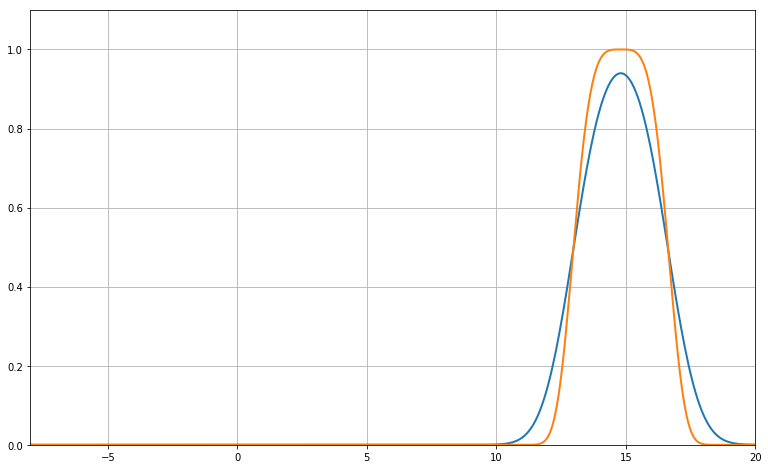

In [5]:
skip_rate = 4
fig, ax = plt.subplots(figsize = (13, 8))
ax.set_xlim((args_dict['a'], args_dict['b']))
ax.set_ylim((0, 1.1))
line, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
plt.grid(True)

def init():
    line.set_data([], [])
    return (line,)

def animate(n):
    line.set_data(x, y[skip_rate*n])
    line2.set_data(x, [phi(args_dict['tau']*skip_rate*n, x_arg, M=args_dict['M'], c=args_dict['c'], d=args_dict['d']) for x_arg in x])
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=len(y)//skip_rate, interval=20, blit=True)
check_errors(x, y, args)
HTML(anim.to_html5_video())

## Разностная схема "кабаре"
$$
\hat{u}_j - u_j + u_{j-1} - \check{u}_{j-1} + 2r(u_j - u_{j-1}) = 0, r = \frac{c\tau}{h}
$$

In [6]:
def kabare_initial_conditions(x, args_list):
    M, c, d, a, b, N, tau, T, r = args_list
    first_layer = [0]*len(x)
    for m in range(len(x)):
        first_layer[m] = phi(0, a + m*(b-a)/N, M=M, c=c, d=d)
    second_layer = [0]*len(x)
    second_layer[0] = phi(0, a, M=M, c=c, d=d)
    for m in range(1, len(x)):
        second_layer[m] = first_layer[m] - r*(first_layer[m] - first_layer[m-1])
    return [first_layer, second_layer]

def kabare_calculate_new_layer(x, y, args_list):
    M, c, d, a, b, N, tau, T, r = args_list
    result = [0]*len(x)
    result[0] = phi(0, a, M=M, c=c, d=d)
    for m in range(1, len(x)):
        result[m] = y[-1][m] - y[-1][m-1] + y[-2][m-1] - 2*r*(y[-1][m] - y[-1][m-1])
    y.append(result)

In [7]:
# args_dict = {'M': 6, 'c': 0.5, 'd': 2, 'a': -4, 'b': 10, 'N': 200, 'tau': 0.05, 'T': 30}
# correct_args(args_dict)
# args = [args_dict[arg] for arg in args_position]
args = common_args
args_dict = common_args_dict
x, y = calculate_scheme(args, kabare_initial_conditions, kabare_calculate_new_layer)

Число Куранта: 0.35714285714285715


Моменты времени: [9.9, 19.8, 29.700000000000003]
Максимальная ошибка: [0.000999403071355931, 0.002025128766392603, 0.0030029331048438967]
Среднеквадратичная ошибка: [0.004860628697249692, 0.009408158755684345, 0.013868521166073865]
Полная вариация: [2.0010919714041115, 2.00191304803611, 2.000454978424215]


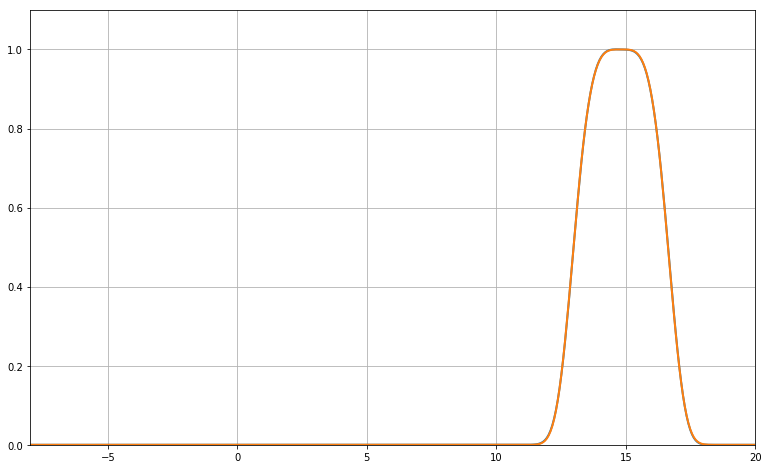

In [8]:
skip_rate = 4
fig, ax = plt.subplots(figsize = (13, 8))
ax.set_xlim((args_dict['a'], args_dict['b']))
ax.set_ylim((0, 1.1))
line, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
plt.grid(True)

def init():
    line.set_data([], [])
    return (line,)

def animate(n):
    line.set_data(x, y[skip_rate*n])
    line2.set_data(x, [phi(args_dict['tau']*skip_rate*n, x_arg, M=args_dict['M'], c=args_dict['c'], d=args_dict['d']) for x_arg in x])
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=len(y)//skip_rate, interval=20, blit=True)
check_errors(x, y, args)
HTML(anim.to_html5_video())

## Разностная схема Лакса-Вендроффа
$$
\large \frac{\hat{u}_j - u_j}{\tau} + \frac{\bar{f}_{j+1/2} - \bar{f}_{j-1/2}}{h} = 0
$$

In [9]:
def lax_initial_conditions(x, args_list):
    M, c, d, a, b, N, tau, T, r = args_list
    result = [0]*len(x)
    for m in range(len(x)):
        result[m] = phi(0, a + m*(b-a)/N, M=M, c=c, d=d)
    return [result]

def lax_calculate_new_layer(x, y, args_list):
    M, c, d, a, b, N, tau, T, r = args_list
    result = [0]*len(x)
    result[0] = phi(0, a, M=M, c=c, d=d)
    for m in range(1, len(x)-1):
        result[m] = y[-1][m] - r*(y[-1][m] - y[-1][m-1]) - r*(1-r)/2*(y[-1][m+1] - 2*y[-1][m] + y[-1][m-1])
    result[-1] = y[-1][-1] - r*(y[-1][-1] - y[-1][-2])
    y.append(result)

In [10]:
# args_dict = {'M': 6, 'c': 0.5, 'd': 2, 'a': -4, 'b': 10, 'N': 200, 'tau': 0.05, 'T': 30}
# correct_args(args_dict)
# args = [args_dict[arg] for arg in args_position]
args = common_args
args_dict = common_args_dict
x, y = calculate_scheme(args, lax_initial_conditions, lax_calculate_new_layer)

Число Куранта: 0.35714285714285715


Моменты времени: [9.9, 19.8, 29.700000000000003]
Максимальная ошибка: [0.009481412327851158, 0.019005834733295646, 0.028188393787842103]
Среднеквадратичная ошибка: [0.04342237296371027, 0.0862973960105595, 0.12845225986787123]
Полная вариация: [2.0042434694449502, 2.017189627618734, 2.0364545089540567]


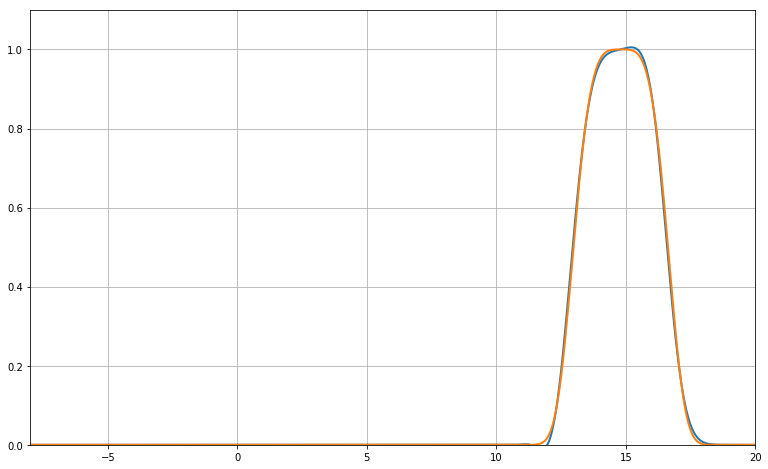

In [11]:
skip_rate = 4
fig, ax = plt.subplots(figsize = (13, 8))
ax.set_xlim((args_dict['a'], args_dict['b']))
ax.set_ylim((0, 1.1))
line, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
plt.grid(True)

def init():
    line.set_data([], [])
    return (line,)

def animate(n):
    line.set_data(x, y[skip_rate*n])
    line2.set_data(x, [phi(args_dict['tau']*skip_rate*n, x_arg, M=args_dict['M'], c=args_dict['c'], d=args_dict['d']) for x_arg in x])
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=len(y)//skip_rate, interval=20, blit=True)
check_errors(x, y, args)
HTML(anim.to_html5_video())